In [1]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Loading & Splitting Data on File Level

In [2]:
from sklearn.model_selection import train_test_split

# Load and preprocess
df = pd.read_parquet("en_merged_df.parquet")
df["speaker_id"] = df["filename"].apply(lambda x: x.split("/wav/")[0])

# Split by speaker to prevent leakage
unique_speakers = df["speaker_id"].unique()
train_speakers, temp_speakers = train_test_split(unique_speakers, test_size=0.3, random_state=42)
val_speakers, test_speakers = train_test_split(temp_speakers, test_size=0.5, random_state=42)

def assign_split(speaker_id):
    if speaker_id in train_speakers:
        return "train"
    elif speaker_id in val_speakers:
        return "val"
    elif speaker_id in test_speakers:
        return "test"
    else:
        return "unknown"

df["split"] = df["speaker_id"].apply(assign_split)

# Label encode gender
le = LabelEncoder()
df["gender_encoded"] = le.fit_transform(df["gender"])
print("Label encoding map:", dict(zip(le.classes_, le.transform(le.classes_))))

# One-hot encode age_range (drop first to avoid dummy variable trap)
df = pd.get_dummies(df, columns=["age_range"], drop_first=True)

# Feature columns
feature_cols = [
    "mean_freq_kHz", "std_freq_kHz", "skewness", "kurtosis",
    "mode_freq_kHz", "sp_entropy", "flatness", "centroid_kHz", "modindx"
] + [col for col in df.columns if col.startswith("age_range_")]

# Final split
X_train = df[df["split"] == "train"][feature_cols]
y_train = df[df["split"] == "train"]["gender_encoded"]

X_val = df[df["split"] == "val"][feature_cols]
y_val = df[df["split"] == "val"]["gender_encoded"]

X_test = df[df["split"] == "test"][feature_cols]
y_test = df[df["split"] == "test"]["gender_encoded"]


Label encoding map: {'female': 0, 'male': 1}


# Computing for Class Weights (Optional XGBoost Parameter)

In [3]:
from collections import Counter

class_counts = Counter(y_train)
print("Original class counts:", class_counts)

minority_class = min(class_counts, key=class_counts.get)
majority_class = max(class_counts, key=class_counts.get)

scale_pos_weight = class_counts[majority_class] / class_counts[minority_class]
print("scale_pos_weight:", scale_pos_weight)


Original class counts: Counter({1: 29269, 0: 2195})
scale_pos_weight: 13.334396355353075


# ML

In [4]:
import optuna
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Feature matrix and labels assumed already defined: X_train, y_train, X_val, y_val, X_test, y_test

def objective(trial):
    # Define the hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
    }

    # Define pipeline
    pipeline = Pipeline([
        ("oversample", RandomOverSampler(random_state=42)),
        ("scaler", StandardScaler()),
        ("classifier", XGBClassifier(**params))
    ])

    # Cross-validation with macro F1-score
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="f1_weighted", n_jobs=-1)
    return np.mean(scores)


/home/jacatacutan-wsl/miniforge3/envs/colab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters found:")
print(study.best_params)


[I 2025-03-23 20:54:16,935] A new study created in memory with name: no-name-3577a814-2acf-42de-acf7-9e4b7d39b116
[I 2025-03-23 20:54:19,143] Trial 0 finished with value: 0.9094444834519644 and parameters: {'n_estimators': 89, 'max_depth': 8, 'learning_rate': 0.20051024961417457, 'subsample': 0.7121727521041852, 'colsample_bytree': 0.5067323672612932, 'gamma': 3.4979588616437436, 'reg_alpha': 0.8322626328273846, 'reg_lambda': 0.1936988764124058}. Best is trial 0 with value: 0.9094444834519644.
[I 2025-03-23 20:54:21,338] Trial 1 finished with value: 0.9126352950276561 and parameters: {'n_estimators': 274, 'max_depth': 7, 'learning_rate': 0.1979497328382318, 'subsample': 0.6044227077124296, 'colsample_bytree': 0.8836020125615403, 'gamma': 4.475382942063524, 'reg_alpha': 0.18180970380238304, 'reg_lambda': 0.8970784168811529}. Best is trial 1 with value: 0.9126352950276561.
[I 2025-03-23 20:54:22,987] Trial 2 finished with value: 0.8986514843194868 and parameters: {'n_estimators': 212, 'm

Best hyperparameters found:
{'n_estimators': 203, 'max_depth': 12, 'learning_rate': 0.14261446491969929, 'subsample': 0.8526685415533714, 'colsample_bytree': 0.9602350701941015, 'gamma': 0.016542598829985877, 'reg_alpha': 0.7313039906897147, 'reg_lambda': 0.6426170520408537}


In [6]:
# Retrain model using best params
best_xgb = XGBClassifier(**study.best_params)

pipeline = Pipeline([
    ("oversample", RandomOverSampler(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", best_xgb)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversample', RandomOverSampler(random_state=42)),
                ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9602350701941015, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gam...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.14261446491969929, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=203,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [7]:

# Evaluation on train
train_preds = pipeline.predict(X_train)
print("\nTrain Accuracy:", accuracy_score(y_train, train_preds))
print("Train Classification Report:")
print(classification_report(y_train, train_preds, target_names=le.classes_))

# Evaluation on validation
val_preds = pipeline.predict(X_val)
print("\nValidation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:")
print(classification_report(y_val, val_preds, target_names=le.classes_))

# Evaluation on test
test_preds = pipeline.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:")
print(classification_report(y_test, test_preds, target_names=le.classes_))

# Optional: print macro F1 explicitly
print("\nMacro F1 (Test):", f1_score(y_test, test_preds, average="macro"))


Train Accuracy: 0.9999046529366895
Train Classification Report:
              precision    recall  f1-score   support

      female       1.00      1.00      1.00      2195
        male       1.00      1.00      1.00     29269

    accuracy                           1.00     31464
   macro avg       1.00      1.00      1.00     31464
weighted avg       1.00      1.00      1.00     31464


Validation Accuracy: 0.9232617297908423
Validation Classification Report:
              precision    recall  f1-score   support

      female       0.45      0.29      0.36       513
        male       0.95      0.97      0.96      6563

    accuracy                           0.92      7076
   macro avg       0.70      0.63      0.66      7076
weighted avg       0.91      0.92      0.92      7076


Test Accuracy: 0.9369356032568468
Test Classification Report:
              precision    recall  f1-score   support

      female       0.33      0.30      0.32       329
        male       0.96      0.97 

In [8]:
print("\nWeighted F1 (Test):", f1_score(y_test, test_preds, average="weighted"))


Weighted F1 (Test): 0.9351986673265006


# Save model as pkl

In [9]:
# joblib.dump(pipeline, "xgb_gender_pipeline.pkl")
# print("✅ Model saved to xgb_gender_pipeline.pkl")


✅ Model saved to xgb_gender_pipeline.pkl


In [ ]:
#pipeline = joblib.load("xgb_gender_pipeline.pkl")


# SHAP

 99%|===================| 6713/6755 [02:28<00:00]        

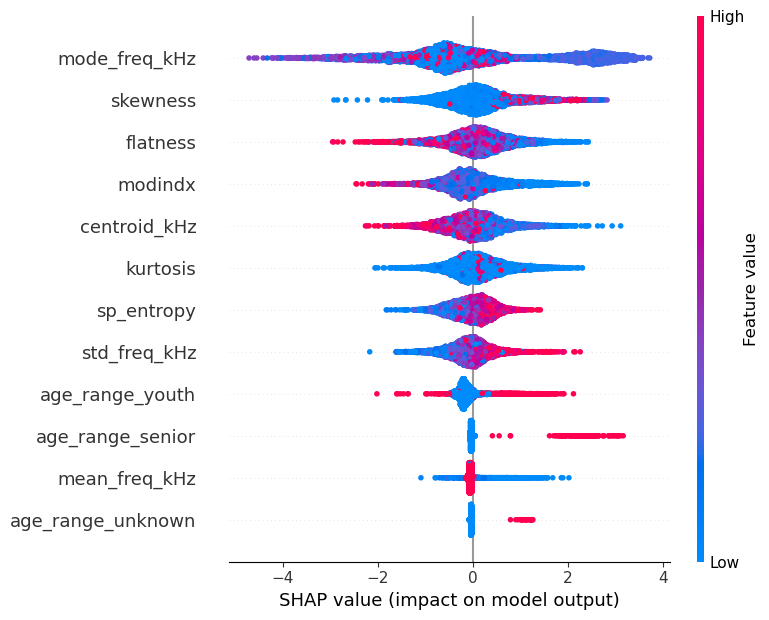

In [12]:
import shap

xgb_model = pipeline.named_steps["classifier"]

X_train_scaled = pipeline.named_steps["scaler"].transform(X_train)

explainer = shap.Explainer(xgb_model, X_train_scaled)

X_test_scaled = pipeline.named_steps["scaler"].transform(X_test)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)
